In [ ]:
## Montando drive para pegar as pastas
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
## Aqui faremos a divisão em memória ao invés de organizar para termos outra opção
data_dir = '/content/drive/MyDrive/Colab Notebooks/fruits' # Dados originais

In [ ]:
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split

# 1 - Preparar a transformação e carregar os dados

# Transformações de data augmentation e normalização
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

# Dividindo os dados em treino (80%), validação (10%) e teste (10%)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

## Note que esta linha de código a seguir executa rápido, isso ocorre porque os dados
## Serão carregados do disco apenas no momento do loop. Em outras palavras,
## o loop pode ficar um pouco mais lento.

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=2,  persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True, num_workers=2,  persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,pin_memory=True, num_workers=2,  persistent_workers=True)

## num_workers controla quantos processos paralelos são usados para carregar os dados.
## persistent_workers=True: O processamento continua entre épocas de treino.
## pin_memory=True: evita paginação de memória ram.

In [ ]:
# 2. Escolhendo Device
import torch

device = "cpu"
if torch.cuda.is_available() :
    device = "cuda"
elif torch.backends.mps.is_available() :
    device = "mps"
print(device)

cuda


In [ ]:
# 3 - Configurando o modelo

import torch.nn as nn
import torch.optim as optim
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self) -> None:
        super(SimpleCNN, self).__init__()
        ## Para o SHAP funcionar, não pode ser assim, tem que ser igual
        ## ao código da documentação visto em sala de aula.

        # self.conv1 = nn.Conv2d(3,32, kernel_size=3, stride = 1, padding=1)
        # self.conv2 = nn.Conv2d(32,64, kernel_size=3, stride = 1, padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding = 0)
        # self.fc1 = nn.Linear(64*32*32, 512)
        # self.fc2 = nn.Linear(512, len(dataset.classes))

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3,32, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding = 0),
            nn.Conv2d(32,64, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding = 0)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64*32*32, 512),
            nn.ReLU(),
            nn.Linear(512, len(dataset.classes))
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 64*32*32)
        x = self.fc_layers(x)
        return x

model =  SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
# 4 - Função de treino e validação
def train_model(model, train_loader, val_loader, num_epochs=1, patience = 5):
    best_val_loss    = np.inf
    early_stop_count = 0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_preds, train_labels = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(train_loader.dataset)
        val_loss, val_preds, val_labels = evaluate(model, val_loader)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_count = 0
            torch.save(model.state_dict(), 'best_model.pth')  # Salvar o melhor modelo
        else:
            early_stop_count += 1
            if early_stop_count >= patience:
                print("Early stopping triggered")
                break

# Função de teste e validação
def evaluate(model, loader):
    model.eval()
    running_loss = 0.0
    preds, labels = [], []
    with torch.no_grad():
        for inputs, label in loader:
            inputs, label = inputs.to(device), label.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, label)
            running_loss += loss.item() * inputs.size(0)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(label.cpu().numpy())
    loss = running_loss / len(loader.dataset)
    return loss, preds, labels

# Treinando o modelo
train_model(model, train_loader, val_loader)

Epoch 1/1, Train Loss: 2.6376, Val Loss: 2.0406


In [ ]:
# 5 - Carregar e avaliar o melhor modelo
#model.load_state_dict(torch.load('best_model.pth'))

# Avaliação nos três conjuntos: treino, validação e teste
train_loss, train_preds, train_labels = evaluate(model, train_loader)
val_loss, val_preds, val_labels = evaluate(model, val_loader)
test_loss, test_preds, test_labels = evaluate(model, test_loader)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# 6 - Calculando as métricas
def print_metrics(y_true, y_pred, dataset_name):
    acc = accuracy_score(y_true, y_pred)
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(y_true, y_pred, average='micro')
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

    print(f"{dataset_name} Accuracy: {acc:.4f}")
    print(f"{dataset_name} Precision (Micro): {precision_micro:.4f}, Recall (Micro): {recall_micro:.4f}, F1-Score (Micro): {f1_micro:.4f}")
    print(f"{dataset_name} Precision (Macro): {precision_macro:.4f}, Recall (Macro): {recall_macro:.4f}, F1-Score (Macro): {f1_macro:.4f}")

print_metrics(train_labels, train_preds, "Train")
print_metrics(val_labels, val_preds, "Validation")
print_metrics(test_labels, test_preds, "Test")


Train Accuracy: 0.2300
Train Precision (Micro): 0.2300, Recall (Micro): 0.2300, F1-Score (Micro): 0.2300
Train Precision (Macro): 0.2148, Recall (Macro): 0.2427, F1-Score (Macro): 0.1388
Validation Accuracy: 0.2286
Validation Precision (Micro): 0.2286, Recall (Micro): 0.2286, F1-Score (Micro): 0.2286
Validation Precision (Macro): 0.1111, Recall (Macro): 0.1607, F1-Score (Macro): 0.0955
Test Accuracy: 0.2162
Test Precision (Micro): 0.2162, Recall (Micro): 0.2162, F1-Score (Micro): 0.2162
Test Precision (Macro): 0.0833, Recall (Macro): 0.2130, F1-Score (Macro): 0.1130


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import shap

batch = next(iter(train_loader))
images, _ = batch

images = images.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)
predicted


background = images[:30]
test_images = images[30:32]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

In [ ]:
batch = next(iter(train_loader))
images, _ = batch
images[0].shape

torch.Size([3, 128, 128])

In [ ]:
shap_numpy = list(np.transpose(shap_values, (4, 0, 2, 3, 1)))
test_numpy = np.swapaxes(np.swapaxes(test_images.to("cpu").numpy(), 1, -1), 1, 2)

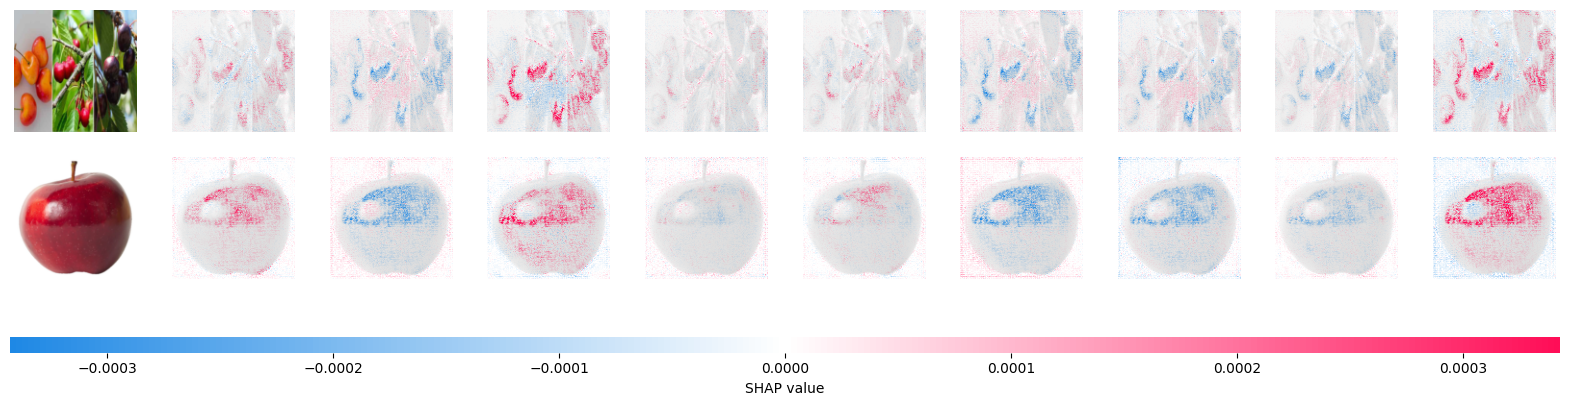

In [ ]:
# Visualização SHAP
shap.image_plot(shap_numpy, test_numpy)